In [8]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [1]:
import json


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=True)

Epoch 1/30
625/625 - 2s - loss: 0.6718 - accuracy: 0.5734 - val_loss: 0.6165 - val_accuracy: 0.5944
Epoch 2/30
625/625 - 2s - loss: 0.4548 - accuracy: 0.8166 - val_loss: 0.3904 - val_accuracy: 0.8386
Epoch 3/30
625/625 - 2s - loss: 0.3167 - accuracy: 0.8751 - val_loss: 0.3623 - val_accuracy: 0.8429
Epoch 4/30
625/625 - 2s - loss: 0.2635 - accuracy: 0.8957 - val_loss: 0.3486 - val_accuracy: 0.8548
Epoch 5/30
625/625 - 2s - loss: 0.2270 - accuracy: 0.9138 - val_loss: 0.3440 - val_accuracy: 0.8551
Epoch 6/30
625/625 - 2s - loss: 0.1986 - accuracy: 0.9233 - val_loss: 0.3503 - val_accuracy: 0.8550
Epoch 7/30
625/625 - 2s - loss: 0.1765 - accuracy: 0.9344 - val_loss: 0.3615 - val_accuracy: 0.8548
Epoch 8/30
625/625 - 2s - loss: 0.1586 - accuracy: 0.9416 - val_loss: 0.3818 - val_accuracy: 0.8501
Epoch 9/30
625/625 - 2s - loss: 0.1444 - accuracy: 0.9481 - val_loss: 0.3937 - val_accuracy: 0.8527
Epoch 10/30
625/625 - 1s - loss: 0.1310 - accuracy: 0.9523 - val_loss: 0.4115 - val_accuracy: 0.8505

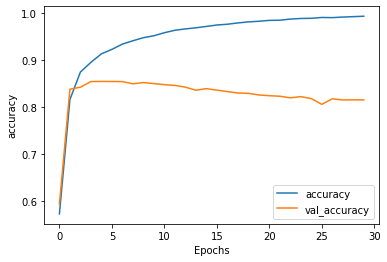

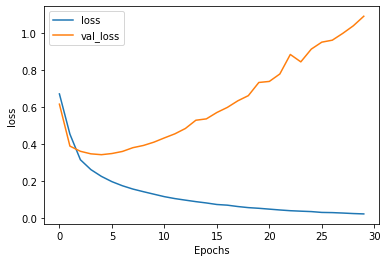

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [15]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [18]:
sentence = ["Sure, Donald Trump is great", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[2.0968832e-07]
 [5.2901200e-06]]


 ## UPLOAD THE META.TSV AND THE VECS.TSV FILE TO TENSORFLOW EMBEDDING PLAYGROUND TO VISUALIZE WORDS EMBEDDED AS VECTORS 
  
  
  <a href="https://projector.tensorflow.org/"> Click here</a>
  
  
  UPLOAD THE FILES AND SELECT SPHERIZE DATA, WE CAN THEN VISUALIZE EACH WORD AS A 16-DIMENSION VECTOR. TO INCREASE THE DIMENSION OF THE VECTOR, INCREASE THE NEURONS IN THE EMBEDDING LAYER OF THE MODEL. 
  <img src='kfsjbj_auto_x1 (1).png'>